In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


<a id="1"></a> <br>
# 1. Import Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score , StratifiedKFold

<a id="1"></a> <br>
# 2. Import Dataset

In [3]:
df_train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
df_test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
df_items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
df_shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
df_item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
df_sub = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')

<a id="1"></a> <br>
# 3. Explore Data

In [4]:
df_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [6]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [7]:
df_test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

We dont have any missing value on train & test data

<a id="1"></a> <br>
# 4. Data Preprocessing

**** Find Outliers****

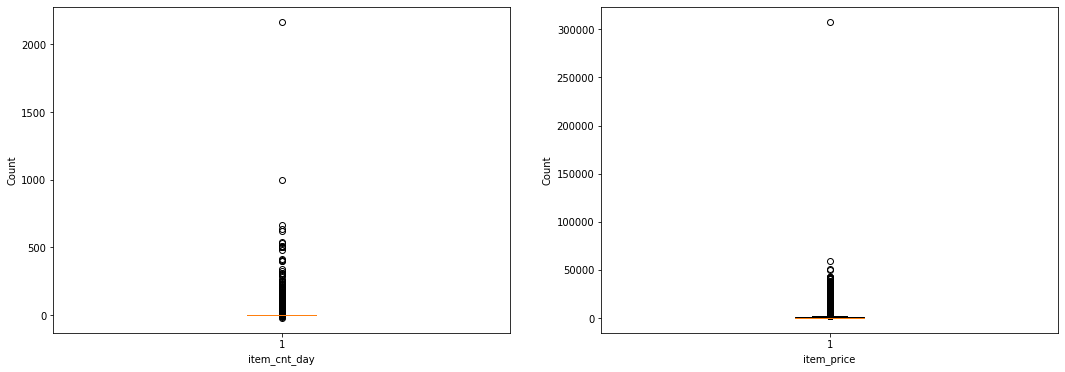

In [8]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(18,6))
# Find outliers in the columns df_train.'item_cnt_day',df_train.'item_price'
cols = ['item_cnt_day','item_price']
for i in range(len(cols)):
    axes[i].boxplot(df_train[cols[i]])
    axes[i].set_xlabel(cols[i])
    axes[i].set_ylabel("Count")
       

**** Remove observed outliers****

In [9]:
# Remove Outliers
outlier1 = df_train[df_train['item_cnt_day']>2000].index[0]
outlier2 = df_train[df_train['item_price']>300000].index[0]
df_train.drop([outlier1,outlier2],axis=0, inplace=True)

# Reset index
df_train.reset_index(inplace=True, drop=True)

****  Find Anomalies****

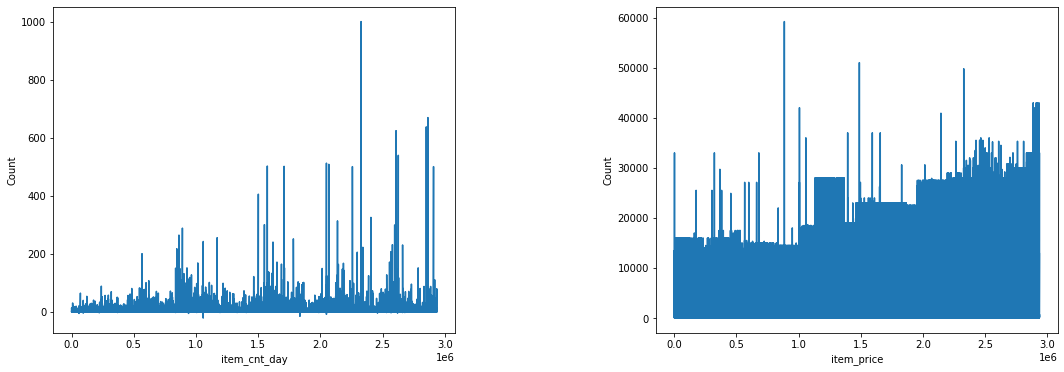

In [10]:
# Find anomalies in the columns df_train.'item_cnt_day',df_train.'item_price'
cols = ['item_cnt_day','item_price']
fig, ax = plt.subplots(ncols = len(cols), figsize = (18,6), sharex = True)
fig.subplots_adjust(wspace=0.5)

for i in range(len(cols)):
  ax[i].plot(df_train[cols[i]])
  ax[i].set_xlabel(cols[i])
  ax[i].set_ylabel("Count")



Observations:

Column 'item_cnt_day' has some negative values which could be items that were 'returned'. Since we will be considering monthly counts, we will leave the negative values in there so that we get a correct count of items sold when we aggregrate by month



<a id="1"></a> <br>
# 5. Feature Engineering

In [11]:
# Get maximum number in column 'date_block_num' representing the last month in data
df_train_max_month = df_train.date_block_num.max()

# Add column 'date_block_num' to the test dataset. The values would be sales_train_max_month + 1 representing next month
df_test['date_block_num'] = df_train_max_month + 1

# Create df_data table to concat modified df_train and df_test
df_data = pd.concat([df_train,df_test]).reset_index(drop=True)

# Create monthly sales data by aggregating on column 'item_cnt_day' and then rename column to 'item_cnt_month'
monthly_sales = df_data.groupby(by = ['date_block_num','shop_id','item_id'], as_index=False).agg({'item_cnt_day':'sum'})

monthly_sales = monthly_sales.rename(columns={'item_cnt_day':'item_cnt_month'})

<a id="1"></a> <br>
# 6. Data Preparation

In [12]:
# The 'date_block_num' must be split as contiguos months of training data and validation data
split_ratio = 0.8
train_valid_split = np.floor(df_train_max_month * split_ratio)
train_data = monthly_sales[monthly_sales['date_block_num'] <= train_valid_split]
valid_data = monthly_sales[(monthly_sales['date_block_num'] > train_valid_split) & (monthly_sales['date_block_num'] < df_train_max_month + 1)]

# Test data will be the 'date_block_num' is sales_train_max_month+1
test_data = monthly_sales[monthly_sales['date_block_num'] == df_train_max_month+1]

In [13]:
# Create X and y variables for train, validation and test sets
X_train = train_data.drop('item_cnt_month',axis=1)
y_train = train_data['item_cnt_month']

X_valid = valid_data.drop('item_cnt_month',axis=1)
y_valid = valid_data['item_cnt_month']

X_test = test_data.drop('item_cnt_month',axis=1)
y_test = test_data['item_cnt_month']

<a id="1"></a> <br>
# 7. Modeling

For the modeling part we will compare 3 known Linear algorithms:

1: LinearRegression

2: Ridge

3: Lasso

In [14]:
# Regression Algorithms
pipeline_LinearRegression = Pipeline([('LinearRegression_Regression',LinearRegression())])
pipeline_Ridge = Pipeline([('Ridge_Regression',Ridge(alpha=0.1))])
pipeline_Lasso = Pipeline([('Lasso_Regression',Lasso(alpha=0.01))])

pipelines = [pipeline_LinearRegression,pipeline_Ridge,pipeline_Lasso]
pipe_dict = {0:'LinearRegression',1:'Ridge',2:'Lasso'}

In [15]:
# Fit Model
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [16]:
# Use model to Predict labels for validation and test sets 
for i,model in enumerate(pipelines):
    train_pred =  model.predict(X_train)
    valid_pred = model.predict(X_valid)
    test_pred = model.predict(X_test)
    # Error metrics
    print('{} Root Mean Square Train Data = {}'.format(pipe_dict[i],np.sqrt(mean_squared_error(y_train,train_pred))))
    print('{} Root Mean Square Validation Data = {}\n'.format(pipe_dict[i],np.sqrt(mean_squared_error(y_valid,valid_pred)))) 

LinearRegression Root Mean Square Train Data = 8.155689348548888
LinearRegression Root Mean Square Validation Data = 10.16685419201607

Ridge Root Mean Square Train Data = 8.155689348548888
Ridge Root Mean Square Validation Data = 10.166854192010785

Lasso Root Mean Square Train Data = 8.155689467887909
Lasso Root Mean Square Validation Data = 10.166769982775508



In [17]:
# Error metrics
print('Root Mean Square Train Data = {}'.format(np.sqrt(mean_squared_error(y_train,train_pred))))
print('Root Mean Square Validation Data = {}'.format(np.sqrt(mean_squared_error(y_valid,valid_pred)))) 

Root Mean Square Train Data = 8.155689467887909
Root Mean Square Validation Data = 10.166769982775508


Submit Predictions

In [18]:
submission = pd.DataFrame(df_test['ID'])
submission['item_cnt_month'] = pipeline_LinearRegression.predict(X_test)
submission.to_csv('submission.csv',index=False)